### Importing the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygmo as pg

from math import sin, cos, exp, pi
from scipy.interpolate import interp1d

### Defining constants

In [2]:
# Universal Constants
PI = pi
GRAVITY = 9.8004                    #! On the surface of the earth, (in m/s2)
RE = 6400000                        #! Radius of the earth (in m)
GM = GRAVITY * pow(RE, 2)

# Used in trajectory equations
I_SP = 400                          #! Specific impulse of the rocket (in s)
ALTITUDES = [0, 50, 100, 200, 400]  #! Pre-defined altitudes (in km)

# Used in MOGA modelling
POPULATION_SIZE = 100
MUTATION_PROBABILITY = [0.04, 0.04, 0.04, 0.04, 0.04]

### Conversion constants

In [3]:
# SS_ENGINE is the RS-25
SS_ENGINE_THRUST        = 2.15e6        #! in N
SS_ENGINE_MASS          = 3500          #! in kg
SS_ENGINE_COST          = 30e6          #! in $

# Liquid propellant cost is the market price available
LIQ_O2_COST             = 0.155         #! in $
LIQ_H2_COST             = 9.5           #! in $

# Structural component
SS_EXT_TANK_MASS        = 760e3         #! in kg
SS_EXT_TANK_COST        = 75e6          #! in $

### Rocket Specifications

In [4]:
THRUST_VECTOR_RANGE = [                         #! in N
    [10.1e6, 10.3e6],
    [ 9.7e6,  9.9e6],
    [10.0e6, 10.2e6],
    [ 3.7e6,  3.9e6],
    [   2e3,    4e3]
]
ANGLE_VECTOR_RANGE = [                          #! in m
    [  350,   450],
    [320e3, 330e3]
]
CONE_HALF_ANGLE    = [ 0.10,  0.15]             #! in radians
ROCKET_RADIUS      = [  3.8,   4.2]             #! in m
TOTAL_MASS         = [950e3, 980e3]             #! in kg

### class RandomVariable
The class has the following variables:
- Public:
    - **thrust_vector**: Randomly generated $T_{1}$, $T_{2}$, $T_{3}$, $T_{4}$ and $T_{5}$
    - **angle_vector**: Randomly generated $\alpha _{1}$ and $\alpha _{2}$
    - **cone_half_angle**: Randomly generated $\theta _{C}$
    - **rocket_radius**: Randomly generated rocket radius
    - **total_mass**: Randomly generated initial wet mass of the rocket $M_{i}$ 

In [5]:
class RandomVariable():
    def __init__(self):
        self.thrust_vector = self.__get_random_thrust_vector()
        self.angle_vector = self.__get_random_angle_vector()
        self.cone_half_angle = self.__get_random_cone_half_radius()
        self.rocket_radius = self.__get_random_rocket_radius()
        self.total_mass = self.__get_random_total_mass()

    def __get_random_thrust_vector(self):
        return [(np.random.random()*(b-a)+a) for a, b in THRUST_VECTOR_RANGE]

    def __get_random_angle_vector(self):
        return [(np.random.random()*(b-a)+a) for a, b in ANGLE_VECTOR_RANGE]

    def __get_random_cone_half_radius(self):
        return (np.random.random()*(CONE_HALF_ANGLE[1]-CONE_HALF_ANGLE[0]) + CONE_HALF_ANGLE[0])

    def __get_random_rocket_radius(self):
        return (np.random.random()*(ROCKET_RADIUS[1]-ROCKET_RADIUS[0]) + ROCKET_RADIUS[0])
    
    def __get_random_total_mass(self):
        return (np.random.random()*(TOTAL_MASS[1]-TOTAL_MASS[0]) + TOTAL_MASS[0])

    def print_details(self):
        print("Thrust vector   : ", self.thrust_vector)
        print("Angle vector    : ", self.angle_vector)
        print("Cone half angle : ", self.cone_half_angle)
        print("Rocket radius   : ", self.rocket_radius)
        print("Total mass      : ", self.total_mass)

### class Rocket
The class has the following variables:
- Private:
    - **__generation**: The generation the rocket belongs to
    - **__thrust_profile**: Linearly interpolated thrust at various altitudes
    - **__angle_profile**: Calculated angle of the rocket w.r.t. normal at various altitudes
    - **__r_max**: Maximum distance from the center of the Earth the rocket reaches
    - **__final_mass**: Final mass at maximum altitude
    - Masses:
        - **__mass_propellant**: Mass of the propellants (fuel + oxidizer)
        - **__mass_engine**: Mass of all the engines combined
        - **__mass_structural**: Structural mass of the rocket
    - **__penalty**: Variable penalty awarded based on the discussed function

- Public:
    - **thrust_vector**: The thrust force at 5 different altitudes
    - **angle_vector**: The altitudes at which gravity turn starts and ends
    - **cone_half_angle**: The half angle formed by the nose cone
    - **rocket_radius**: Radius of the rocket
    - **total_mass**: Initial Wet mass of the rocket
    - **mass_payload**: Payload capacity
    - **total_cost**: Price of the rocket
    - **mass_to_cost_ratio**: Self explanatory
    - **fitness**: Fitness of the model based on the discussed function

In [6]:
class Rocket():
    def __init__(self, thrust_vector, angle_vector, cone_half_angle, rocket_radius, total_mass, generation):
        # Pre-determined parameters
        self.thrust_vector = thrust_vector
        self.angle_vector = angle_vector
        self.cone_half_angle = cone_half_angle
        self.rocket_radius = rocket_radius
        self.total_mass = total_mass
        self.__generation = generation

        # Profile generation
        self.__thrust_profile = self.__calc_thrust_profile()
        self.__angle_profile = self.__calc_angle_profile()
        self.__r_max, self.__final_mass = self.__calc_end_points()

        # Intermediate paramters
        self.__mass_propellant, self.__mass_engine, self.__mass_structural, self.mass_payload = self.__calc_masses()
        self.total_cost = self.__calc_total_cost()

        # Final paramters
        self.__penalty = self.__calc_penalty()
        self.mass_to_cost_ratio = self.mass_payload / self.total_cost
        self.fitness = 0
    
    # Linear interpolation of thrust force
    def __calc_thrust_profile(self):
        interp_func = interp1d(ALTITUDES, self.thrust_vector)
        return interp_func(range(401))

    # Calculation of angle at any altitude
    def __calc_angle_profile(self):
        angle_profile = []
        alpha1, alpha2 = self.angle_vector
        i = 0
        while i < alpha1:
            angle_profile.append(0)
            i += 1000
        while i < alpha1+alpha2:
            angle_profile.append(PI/4 * (1 - cos(PI * (i-alpha1) / alpha2)))
            i += 1000
        while i <= 400e3:
            angle_profile.append(PI/2)
            i += 1000
        return angle_profile

    # Calculating rocket profiles
    def __calc_end_points(self):
        i = 0
        Z = [RE, 0.0, 0.0, 0.0, self.total_mass]
        while (Z[1] >= 0):
            Z_dash = self.__calc_derivatives(Z)
            for j in range(5):
                Z[j] += Z_dash[j] * 0.01
            i += 1
        return Z[0], Z[4]

    # Calculating masses
    def __calc_masses(self):
        mass_engine = (self.thrust_vector[0] / SS_ENGINE_THRUST) * SS_ENGINE_MASS
        mass_propellant = self.total_mass - self.__final_mass
        mass_structural = self.total_mass * 0.15
        mass_payload = self.total_mass - (mass_engine + mass_propellant + mass_structural)
        return mass_propellant, mass_engine, mass_structural, mass_payload

    # Calculating total cost
    def __calc_total_cost(self):
        cost_engine = (self.__mass_engine / SS_ENGINE_MASS) * SS_ENGINE_COST
        cost_propellant = (self.__mass_propellant * (6/7) * LIQ_O2_COST) + (self.__mass_propellant * (1/7) * LIQ_H2_COST)
        cost_structural = (self.__mass_structural / SS_EXT_TANK_MASS) * SS_EXT_TANK_COST
        return (cost_propellant + cost_engine + cost_structural)

    # Calculating penalty
    def __calc_penalty(self):
        A_final = (self.__r_max - RE) / 1000
        _max = max(1, 400-4*self.__generation)
        return (abs(400 - A_final) / _max)

    # Calculating fitness
    def calc_fitness(self, n_dom):
        self.fitness = pow(max(1.0 - 0.01*n_dom - self.__penalty, 0), 2)

    #! Next generation function -----------------------------------
    def mate(self, par2, new_generation):
        random_variable = RandomVariable()
        probability = [np.random.random(), np.random.random(), np.random.random(), np.random.random(), np.random.random()]
        if (probability[0] < 0.5-MUTATION_PROBABILITY[0]/2):
            new_thrust_vector = self.thrust_vector
        elif (probability[0] < 1-MUTATION_PROBABILITY[0]):
            new_thrust_vector = par2.thrust_vector
        else:
            new_thrust_vector = random_variable.thrust_vector
        if (probability[1] < 0.5-MUTATION_PROBABILITY[1]/2):
            new_angle_vector = self.angle_vector
        elif (probability[1] < 1-MUTATION_PROBABILITY[1]):
            new_angle_vector = par2.angle_vector
        else:
            new_angle_vector = random_variable.angle_vector
        if (probability[2] < 0.5-MUTATION_PROBABILITY[2]/2):
            new_cone_half_angle = self.cone_half_angle
        elif (probability[2] < 1-MUTATION_PROBABILITY[2]):
            new_cone_half_angle = par2.cone_half_angle
        else:
            new_cone_half_angle = random_variable.cone_half_angle
        if (probability[3] < 0.5-MUTATION_PROBABILITY[3]/2):
            new_rocket_radius = self.rocket_radius
        elif (probability[3] < 1-MUTATION_PROBABILITY[3]):
            new_rocket_radius = par2.rocket_radius
        else:
            new_rocket_radius = random_variable.rocket_radius
        if (probability[4] < 0.5-MUTATION_PROBABILITY[4]/2):
            new_total_mass = self.total_mass
        elif (probability[4] < 1-MUTATION_PROBABILITY[4]):
            new_total_mass = par2.total_mass
        else:
            new_total_mass = random_variable.total_mass
        return Rocket(new_thrust_vector, new_angle_vector, new_cone_half_angle, new_rocket_radius, new_total_mass, new_generation)

    # Helper functions
    def __get_thrust(self, r):
        alt = int(r/1000 - 6400)
        if (alt > 400):
            return 0
        return self.__thrust_profile[alt]
    
    def __get_angle(self, r):
        alt = int(r/1000 - 6400)
        if (alt > 400):
            return PI/2
        return self.__angle_profile[alt]

    def __get_density(self, r):
        alt = r/1000 - 6400
        return (1.2 * exp(-1 * alt / 10.4))

    def __get_drag(self, r, v):
        density = self.__get_density(r)
        coeff_of_drag = 2 * pow(sin(self.cone_half_angle), 2)
        rocket_area = PI * pow(self.rocket_radius, 2)
        return (0.5 * coeff_of_drag * rocket_area * density * pow(v, 2))

    def __calc_derivatives(self, Z):
        r, r_dash, theta, theta_dash, m = Z
        thrust = self.__get_thrust(r)
        drag = self.__get_drag(r, r_dash)
        angle = self.__get_angle(r)
        x1 = r_dash
        x2 = -(GM / pow(r, 2)) + (r * pow(theta_dash, 2)) + ((thrust - drag) * cos(angle) / m)
        x3 = theta_dash
        x4 = (thrust - drag) * sin(angle) / (r * m)
        x5 = -1 * thrust / (I_SP * GRAVITY)
        return np.array((x1, x2, x3, x4, x5))

    def print_details(self):
        print("Payload Mass: {} kg".format(round(self.mass_payload, 2)))
        print("Total Cost  : {} million $".format(round(self.total_cost/1e6, 2)))

### Testing a Sample Rocket

In [7]:
rv = RandomVariable()
sample_rocket = Rocket(rv.thrust_vector, rv.angle_vector, rv.cone_half_angle, rv.rocket_radius, rv.total_mass, 1)
sample_rocket.print_details()

Payload Mass: 52460.74 kg
Total Cost  : 159.18 million $


### class Generation
The class has the following variables:
- Private:
    - **__parents**: The sorted population of the previous generation
    - **__number**: The number of the current generation

- Public:
    - **population**: The sorted population of the offsprings produced by the parents

In [8]:
class Generation():
    def __init__(self, parents, number):
        self.__parents = parents
        self.__number = number
        self.population = self.__reproduce()
        self.__calc_fitness()

    def __reproduce(self):
        population = []
        population.extend(self.__parents[:10])
        for _ in range(90):
            par1 = np.random.choice(self.__parents[:30])
            par2 = np.random.choice(self.__parents[:30])
            child = par1.mate(par2, self.__number)
            population.append(child)
        return population

    def __calc_fitness(self):
        population_copy = []
        dominance = 0
        for p in self.population:
            population_copy.append(p)
        while (len(population_copy) > 0):
            points = [[-1*i.mass_payload, i.total_cost] for i in population_copy]
            di = pg.non_dominated_front_2d(points=points)
            for j in di:
                for p in self.population:
                    self.population[j].calc_fitness(0)
                    break
            pc = []
            for j in range(len(population_copy)):
                if j not in di:
                    pc.append(population_copy[j])
            population_copy = pc
            dominance += 1
        self.population = sorted(self.population, key=lambda x: -1*x.fitness)

    def plot(self):
        plt.figure(figsize=(12, 8))
        plt.scatter([i.mass_payload for i in self.population], [i.total_cost for i in self.population])
        plt.xlabel("Payload Mass (in kg)")
        plt.ylabel("Total Cost (in $)")
        plt.title("Generation #" + str(self.__number))
        plt.show()

In [9]:
population = []
generation = 1

for i in range(100):
    if ((i+1)%10 == 0):
        print("Generating rocket #{}".format(i+1))
    rv = RandomVariable()
    rocket = Rocket(rv.thrust_vector, rv.angle_vector, rv.cone_half_angle, rv.rocket_radius, rv.total_mass, generation)
    population.append(rocket)

Generating rocket #10
Generating rocket #20
Generating rocket #30
Generating rocket #40
Generating rocket #50
Generating rocket #60
Generating rocket #70
Generating rocket #80
Generating rocket #90
Generating rocket #100


In [10]:
population_copy = []
dominance = 0
for p in population:
    population_copy.append(p)
while (len(population_copy) > 0):
    points = [[-1*i.mass_payload, i.total_cost] for i in population_copy]
    di = pg.non_dominated_front_2d(points=points)
    for j in di:
        for p in population:
            population[j].calc_fitness(0)
            break
    pc = []
    for j in range(len(population_copy)):
        if j not in di:
            pc.append(population_copy[j])
    population_copy = pc
    dominance += 1
population = sorted(population, key=lambda x: -1*x.fitness)

Payload Mass: 53474.78 kg
Total Cost  : 158.95 million $


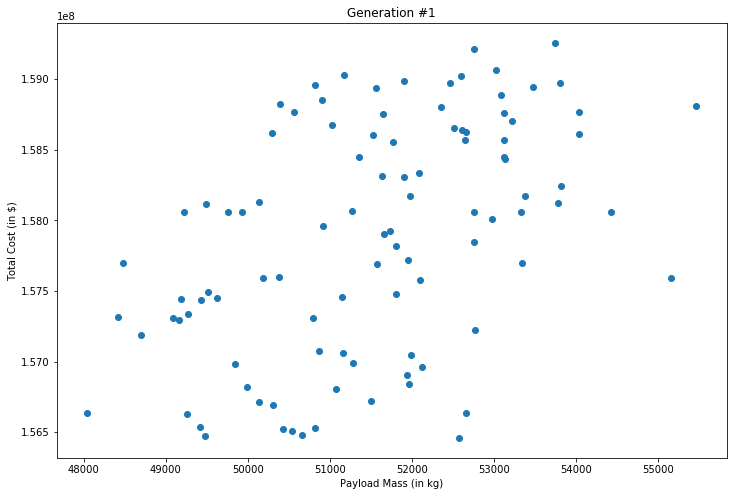

In [11]:
population[0].print_details()

plt.figure(figsize=(12, 8))
plt.scatter([i.mass_payload for i in population], [i.total_cost for i in population])
plt.xlabel("Payload Mass (in kg)")
plt.ylabel("Total Cost (in $)")
plt.title("Generation #" + str(generation))
plt.show()

Payload Mass: 53474.78 kg
Total Cost  : 158.95 million $


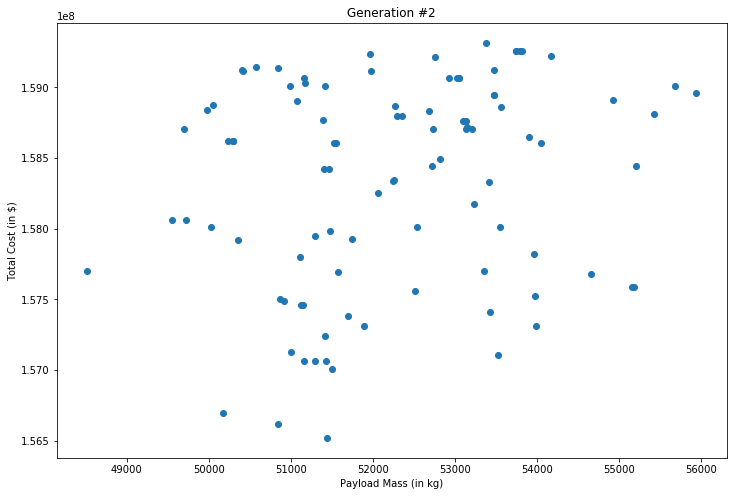

Payload Mass: 53474.78 kg
Total Cost  : 158.95 million $


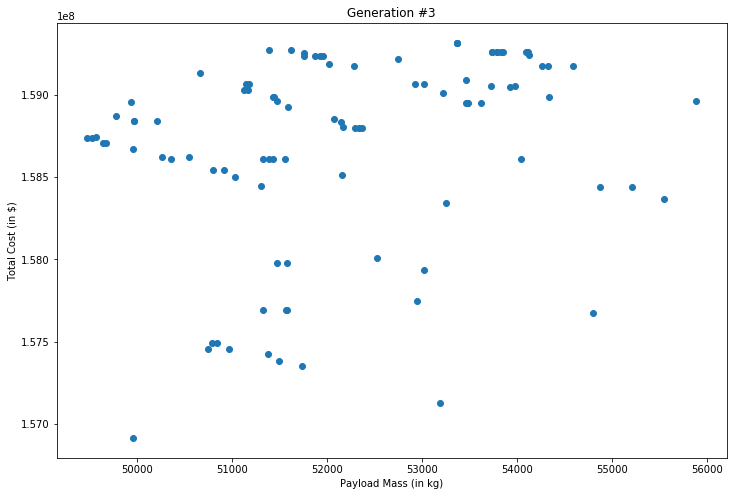

Payload Mass: 53474.78 kg
Total Cost  : 158.95 million $


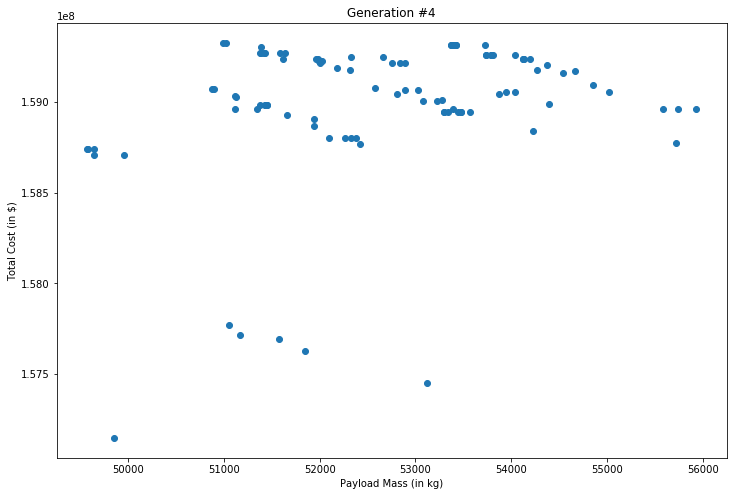

Payload Mass: 52818.27 kg
Total Cost  : 159.04 million $


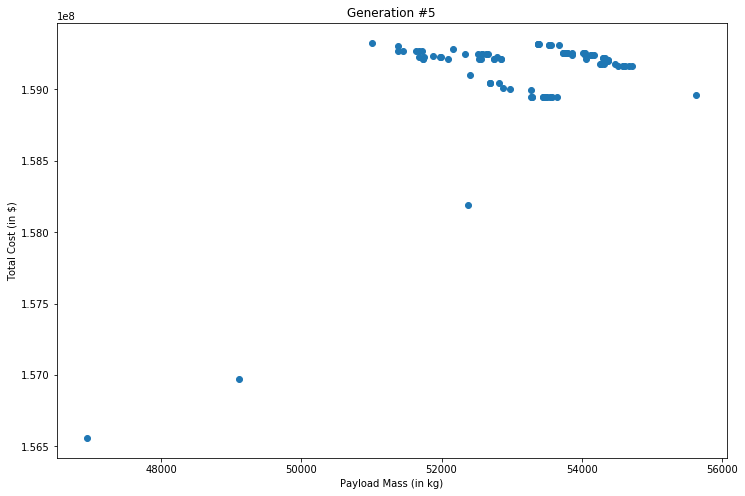

In [12]:
for i in range(2, 6):
    gen = Generation(population, i)
    population = gen.population
    population[0].print_details()
    gen.plot()